In [13]:
import pandas as pd
import seaborn as sns
import matplotlib as plt


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

import pickle

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/MLopsJaf/homeworks/mlruns/1', creation_time=1717006451345, experiment_id='1', last_update_time=1717006451345, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df['dow_tpep_pickup'] = df['tpep_pickup_datetime'].dt.day_name()
    df['dow_tpep_dropoff'] = df['tpep_dropoff_datetime'].dt.day_name()

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID','dow_tpep_pickup','dow_tpep_dropoff','payment_type']
    df[categorical] = df[categorical].astype(str)

    return df

In [4]:
df_train = read_dataframe('/workspaces/MLopsJaf/data/yellow_tripdata_2024-01.parquet')
df_val = read_dataframe('/workspaces/MLopsJaf/data/yellow_tripdata_2024-02.parquet')

In [11]:
df_train_before_tf  = pd.read_parquet('/workspaces/MLopsJaf/data/yellow_tripdata_2024-01.parquet')


In [14]:

df_train_before_tf['duration'] = df_train_before_tf.tpep_dropoff_datetime - df_train_before_tf.tpep_pickup_datetime
df_train_before_tf.duration = df_train_before_tf.duration.apply(lambda td: td.total_seconds() / 60)


In [15]:
df_train_before_tf['duration'].std(axis=0)

34.851053592212814

In [6]:
df_train['duration'].describe()

count    2.898906e+06
mean     1.441373e+01
std      1.015959e+01
min      1.000000e+00
25%      7.250000e+00
50%      1.165000e+01
75%      1.848333e+01
max      6.000000e+01
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Count'>

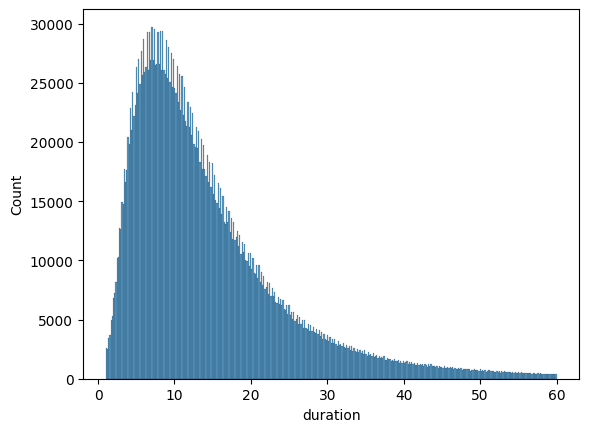

In [7]:
sns.histplot(df_train['duration'])

In [4]:
df_train.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration,dow_tpep_pickup,dow_tpep_dropoff
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,0.5,0.00,0.0,1.0,22.70,2.5,0.0,19.8,Monday,Monday
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6.6,Monday,Monday


In [17]:
df_train[['fare_amount','extra','mta_tax','tip_amount','tolls_amount','total_amount']].head(5)

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,17.7,1.0,0.5,0.00,0.0,22.70
1,10.0,3.5,0.5,3.75,0.0,18.75
2,23.3,3.5,0.5,3.00,0.0,31.30
3,10.0,3.5,0.5,2.00,0.0,17.00
4,7.9,3.5,0.5,3.20,0.0,16.10


In [20]:
df_train[['fare_amount','extra','tip_amount','tolls_amount','mta_tax','improvement_surcharge']].sum(axis=1).head(5)

0    20.20
1    18.75
2    31.30
3    17.00
4    16.10
dtype: float64

In [7]:
df_train.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dow_tpep_pickup                  object
dow_tpep_dropoff                 object
dtype: object

In [5]:
df_train['dow'] = df_train['dow_tpep_pickup']+ '_' + df_train['dow_tpep_dropoff']
df_val['dow'] = df_val['dow_tpep_pickup']+ '_' + df_val['dow_tpep_dropoff']

In [5]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
categorical = ['PU_DO','dow','payment_type']#'dow_tpep_pickup','dow_tpep_dropoff'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance','total_amount']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

: 

In [6]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.502786179844923

In [ ]:
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

In [24]:
X_train.shape

(2898906, 518)

In [6]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

: 

In [6]:
X_train = df_train['PU_DO'].values
X_val = df_val['PU_DO'].values

X_train = X_train.reshape(-1,1)
X_val = X_val.reshape(-1,1)

In [14]:
X_train

array([['186_79'],
       ['140_236'],
       ['236_79'],
       ...,
       ['211_25'],
       ['107_13'],
       ['138_75']], dtype=object)

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
with mlflow.start_run():
    
    mlflow.set_tag("developer","jafet") #quien hizo 
    mlflow.log_param("train_data_path","/workspaces/MLopsJaf/data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_data_path","/workspaces/MLopsJaf/data/yellow_tripdata_2024-02.parquet")
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.12339298062458

In [16]:
with mlflow.start_run():
    mlflow.set_tag("developer","jafet")
    mlflow.log_param("train_data_path","/workspaces/MLopsJaf/data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("validation_data_path","/workspaces/MLopsJaf/data/yellow_tripdata_2024-02.parquet")

    alpha=0.1
    mlflow.log_param("alpha",alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|                                                                                                  | 0/5 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:15:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.75778                                                                                                                  
[1]	validation-rmse:9.40724                                                                                                                  
[2]	validation-rmse:9.16166                                                                                                                  
[3]	validation-rmse:8.99088                                                                                                                  
[4]	validation-rmse:8.87267                                                                                                                  
[5]	validation-rmse:8.79106                                                                                                                  
[6]	validation-rmse:8.73476                                                                                                                  
[7]	va

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:15:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01899                                                                                                                 
[1]	validation-rmse:9.81673                                                                                                                  
[2]	validation-rmse:9.64235                                                                                                                  
[3]	validation-rmse:9.49234                                                                                                                  
[4]	validation-rmse:9.36353                                                                                                                  
[5]	validation-rmse:9.25311                                                                                                                  
[6]	validation-rmse:9.15859                                                                                                                  
[7]	va

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:16:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.91837                                                                                                                  
[1]	validation-rmse:9.65020                                                                                                                  
[2]	validation-rmse:9.43786                                                                                                                  
[3]	validation-rmse:9.26950                                                                                                                  
[4]	validation-rmse:9.13659                                                                                                                  
[5]	validation-rmse:9.03276                                                                                                                  
[6]	validation-rmse:8.94981                                                                                                                  
[7]	va

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:16:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.61226                                                                                                                  
[1]	validation-rmse:9.21567                                                                                                                  
[2]	validation-rmse:8.97421                                                                                                                  
[3]	validation-rmse:8.82857                                                                                                                  
[4]	validation-rmse:8.74107                                                                                                                  
[5]	validation-rmse:8.68847                                                                                                                  
[6]	validation-rmse:8.65673                                                                                                                  
[7]	va

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:17:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.65348                                                                                                                  
[1]	validation-rmse:9.26724                                                                                                                  
[2]	validation-rmse:9.02203                                                                                                                  
[3]	validation-rmse:8.86775                                                                                                                  
[4]	validation-rmse:8.77111                                                                                                                  
[5]	validation-rmse:8.71062                                                                                                                  
[6]	validation-rmse:8.67268                                                                                                                  
[7]	va

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

